<a href="https://www.kaggle.com/code/yaaangzhou/playground-s3-e16-eda-modelling?scriptVersionId=138623931" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

###### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Imports

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 400)
pd.set_option('display.max_columns', None)

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import matplotlib.colors as plt_colors
import plotly.express as px

import optuna
from optuna.samplers import TPESampler
from optuna.pruners import HyperbandPruner

from xgboost import XGBRegressor, plot_importance

# Summary and EDA

In [2]:
# Read in the data
data_dir = Path('../input/playground-series-s3e16')
train = pd.read_csv(data_dir/'train.csv', index_col=None)
test = pd.read_csv(data_dir/'test.csv', index_col=None)
submission = pd.read_csv(data_dir/'sample_submission.csv')

target = 'Age'

var_cat = ['Sex']
var_num = ['Length', 'Diameter', 'Height', 'Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight']

In [3]:
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    summ['unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values    
    return summ

summary(train)

data shape: (74051, 10)


,data type,missing,%missing,unique,min,max,first value,second value,third value
id,int64,0,0.0,74051,0.0,74050.0,0,1,2
Sex,object,0,0.0,3,NaN,NaN,I,I,M
Length,float64,0,0.0,144,0.1875,2.012815,1.525,1.1,1.3875
Diameter,float64,0,0.0,122,0.1375,1.6125,1.175,0.825,1.1125
Height,float64,0,0.0,65,0.0,2.825,0.375,0.275,0.375
Weight,float64,0,0.0,3096,0.056699,80.101512,28.973189,10.418441,24.777463
Shucked Weight,float64,0,0.0,1766,0.028349,42.184056,12.728926,4.521745,11.3398
Viscera Weight,float64,0,0.0,967,0.042524,21.54562,6.647958,2.324659,5.556502
Shell Weight,float64,0,0.0,1048,0.042524,28.491248,8.348928,3.40194,6.662133
Age,int64,0,0.0,28,1.0,29.0,9,8,9


# EDA

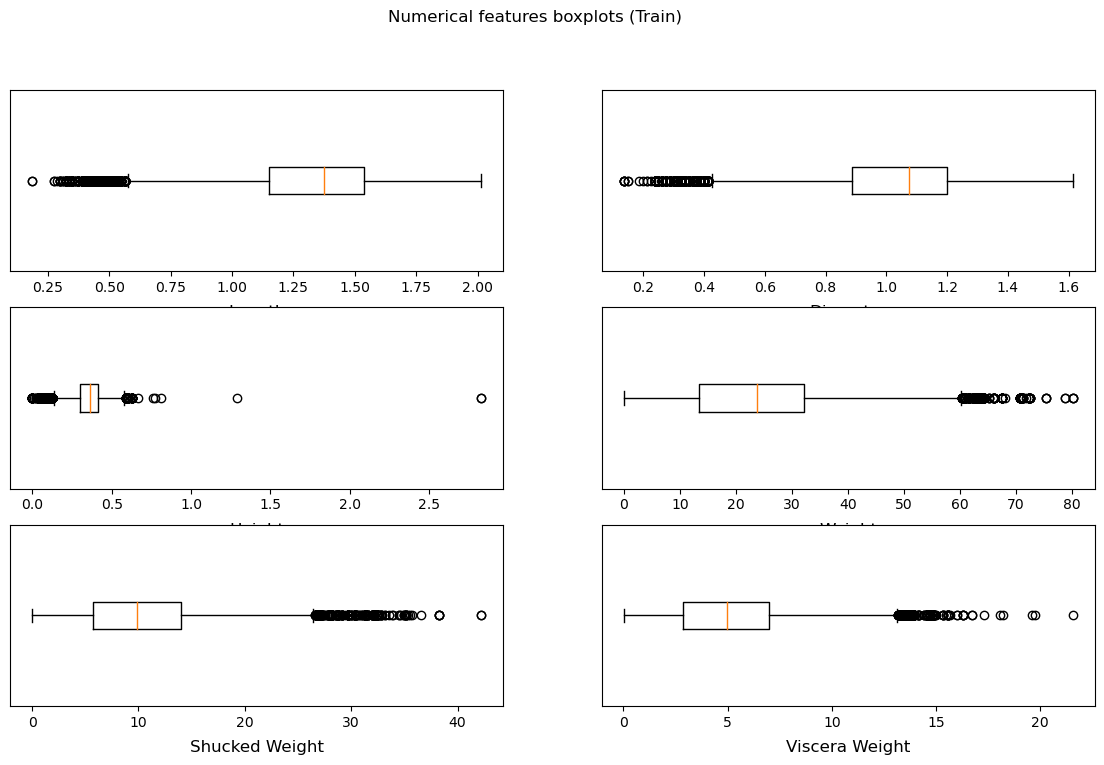

In [4]:
# Variables numericas

fig, axes = plt.subplots(3, 2, figsize=(14,8))
# plt.subplots_adjust(hspace=0.4)


for ax, i in zip(axes.reshape(-1), var_num):
    ax.boxplot(x=train[i], vert=False)
    ax.set_title(i, y=-.3)
    ax.set_yticks([])

fig.suptitle('Numerical features boxplots (Train)', fontsize=12)
plt.show()

In [5]:
corr = train.drop(var_cat+['id'], axis=1).corr()
corr.style.background_gradient().format(precision=2)

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
Length,1.00,0.99,0.92,0.94,0.92,0.92,0.92,0.61
Diameter,0.99,1.00,0.92,0.94,0.91,0.92,0.92,0.62
Height,0.92,0.92,1.00,0.90,0.86,0.88,0.90,0.64
Weight,0.94,0.94,0.90,1.00,0.97,0.97,0.97,0.60
Shucked Weight,0.92,0.91,0.86,0.97,1.00,0.94,0.91,0.50
Viscera Weight,0.92,0.92,0.88,0.97,0.94,1.00,0.93,0.58
Shell Weight,0.92,0.92,0.90,0.97,0.91,0.93,1.00,0.66
Age,0.61,0.62,0.64,0.60,0.50,0.58,0.66,1.00


# Feature Engineering

In [6]:
# OneHoter Encoding for var_cat

encoding = OneHotEncoder()
ohe_train = pd.DataFrame(encoding.fit_transform(train[var_cat]).toarray(), columns=encoding.get_feature_names_out())
train.drop(var_cat, axis=1, inplace=True)
train = pd.concat([train, ohe_train], axis=1)

ohe_test = pd.DataFrame(encoding.transform(test[var_cat]).toarray(), columns=encoding.get_feature_names_out())
test.drop(var_cat, axis=1, inplace=True)
test = pd.concat([test, ohe_test], axis=1)

In [7]:
features = train.columns.drop([target, 'id']).to_list()
y_train = train['Age']
train = train[features]
test = test[features]

In [8]:
train.head()

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Sex_F,Sex_I,Sex_M
0,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,0.0,1.0,0.0
1,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,0.0,1.0,0.0
2,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,0.0,0.0,1.0
3,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,1.0,0.0,0.0
4,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,0.0,1.0,0.0


In [9]:
'''from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer()

for i in var_num:
    df_train[i] = pt.fit_transform(df_train[[i]])
    df_test[i] = pt.transform(df_test[[i]])'''

'from sklearn.preprocessing import PowerTransformer\n\npt = PowerTransformer()\n\nfor i in var_num:\n    df_train[i] = pt.fit_transform(df_train[[i]])\n    df_test[i] = pt.transform(df_test[[i]])'

# Hyperparameters

In [10]:
def creat_model(param):
    return XGBRegressor(random_state=42,  
                        tree_method='gpu_hist',
                        eval_metric= 'mae',
                        objective='reg:absoluteerror',
                        early_stopping_rounds=100,
                        **param
                       )

def train_model(param,X,y,X_test,n_splits=5,trial=None):
    skf = KFold(n_splits = n_splits,shuffle = True,random_state=42)
    y_test = []
    validation = y.copy(deep=True)
    valid_score = []
    models = []
    
    for fold,(idx_train,idx_val) in enumerate(skf.split(X,y)):
        print(f'Fold: {fold+1}/{n_splits}')   
        X_train,y_train = X.iloc[idx_train],y.iloc[idx_train]
        X_val,y_val = X.iloc[idx_val],y.iloc[idx_val]
        
        model = creat_model(param)
        model.fit(X_train,y_train,
                 eval_set=[(X_train, y_train), (X_val, y_val)],
                 verbose = 1000)
        
        y_hat_val = model.predict(X_val)
        validation.iloc[y_val.index] = y_hat_val
        score = mean_absolute_error(y_val.values,y_hat_val)
        valid_score.append(score)
        print(f'Fold: {fold+1}/{n_splits} score = {score:.5f}')
        
        y_test.append(model.predict(X_test))
        models.append(model)
        
        if trial:
            trial.report(score, fold)

            if trial.should_prune():
                raise optuna.TrialPruned()    
    
    return validation, y_test, valid_score, models


In [11]:
'''from sklearn.metrics import mean_absolute_error

def obj_xgb(trial):
    param = {
        'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']), 
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.2, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
        'n_estimators' : trial.suggest_int('n_estimators', 100, 1000, step=100)
    }
    
    if(param['booster'] in ['gbtree', 'dart']):
        # maximum depth of the tree, signifies complexity of the tree.
        param['max_depth'] = trial.suggest_int('max_depth', 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param['min_child_weight'] = trial.suggest_int('min_child_weight', 2, 10)
        param['eta'] = trial.suggest_float('eta', 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param['gamma'] = trial.suggest_float('gamma', 1e-8, 1.0, log=True)
        param['grow_policy'] = trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])

    if(param['booster'] == 'dart'):
        param['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
        param['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
        param['rate_drop'] = trial.suggest_float('rate_drop', 1e-8, 1.0, log=True)
        param['skip_drop'] = trial.suggest_float('skip_drop', 1e-8, 1.0, log=True)

    validation, y_hat_test, validation_scores, trained_models = train_model(param, train, y_train, test, 8, trial) 
    
    return mean_absolute_error(y_train.values, validation)


study = optuna.create_study(
    sampler=TPESampler(seed=42),
    direction='minimize',
    study_name='xgb_tuning',
    pruner=HyperbandPruner(
        min_resource=1, max_resource=8, reduction_factor=3
    ),
)
study.optimize(obj_xgb, n_trials=1000, timeout=7*60*60)'''

"from sklearn.metrics import mean_absolute_error\n\ndef obj_xgb(trial):\n    param = {\n        'booster': trial.suggest_categorical('booster', ['gbtree', 'dart']), \n        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),\n        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),\n        'subsample': trial.suggest_float('subsample', 0.2, 1.0),\n        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),\n        'n_estimators' : trial.suggest_int('n_estimators', 100, 1000, step=100)\n    }\n    \n    if(param['booster'] in ['gbtree', 'dart']):\n        # maximum depth of the tree, signifies complexity of the tree.\n        param['max_depth'] = trial.suggest_int('max_depth', 3, 9, step=2)\n        # minimum child weight, larger the term more conservative the tree.\n        param['min_child_weight'] = trial.suggest_int('min_child_weight', 2, 10)\n        param['eta'] = trial.suggest_float('eta', 1e-8, 1.0, log=True)\n        # defines how sele

In [12]:
'''print(f'Finished trials: {len(study.trials)}')
print('Best trial:')
trial = study.best_trial
print(f'Best Score: {trial.value:.5f}')
print(f'Best Params: {trial.params}')# Data split'''


"print(f'Finished trials: {len(study.trials)}')\nprint('Best trial:')\ntrial = study.best_trial\nprint(f'Best Score: {trial.value:.5f}')\nprint(f'Best Params: {trial.params}')# Data split"

In [13]:
best_params = {'booster': 'dart', 
               'lambda': 1.3564242299917567e-06, 
               'alpha': 6.657736811017855e-08, 
               'subsample': 0.9987885488425374, 
               'colsample_bytree': 0.9748449420972439, 
               'n_estimators': 200, 
               'max_depth': 7, 
               'min_child_weight': 10, 
               'eta': 6.015791017774553e-07, 
               'gamma': 0.5513468186878823, 
               'grow_policy': 'depthwise', 
               'sample_type': 'uniform', 
               'normalize_type': 'forest', 
               'rate_drop': 2.765721277981557e-05, 
               'skip_drop': 3.569660132300492e-05}
validation, y_hat_test, validation_scores, models = train_model(best_params, train, y_train, test, 8)

Fold: 1/8
[0]	validation_0-mae:1.38463	validation_1-mae:1.40607
[103]	validation_0-mae:1.24393	validation_1-mae:1.44698
Fold: 1/8 score = 1.38576
Fold: 2/8
[0]	validation_0-mae:1.38170	validation_1-mae:1.40359
[101]	validation_0-mae:1.22029	validation_1-mae:1.44716
Fold: 2/8 score = 1.37963
Fold: 3/8
[0]	validation_0-mae:1.38595	validation_1-mae:1.40191
[103]	validation_0-mae:1.21539	validation_1-mae:1.45956
Fold: 3/8 score = 1.37784
Fold: 4/8
[0]	validation_0-mae:1.39897	validation_1-mae:1.38818
[100]	validation_0-mae:1.21937	validation_1-mae:1.43048
Fold: 4/8 score = 1.34729
Fold: 5/8
[0]	validation_0-mae:1.38784	validation_1-mae:1.40098
[100]	validation_0-mae:1.25924	validation_1-mae:1.44439
Fold: 5/8 score = 1.38586
Fold: 6/8
[0]	validation_0-mae:1.37890	validation_1-mae:1.46354
[102]	validation_0-mae:1.18641	validation_1-mae:1.52106
Fold: 6/8 score = 1.43094
Fold: 7/8
[0]	validation_0-mae:1.39795	validation_1-mae:1.38073
[101]	validation_0-mae:1.21952	validation_1-mae:1.42857
Fold

# Best model

In [14]:
submission[target] = np.round(np.mean(y_hat_test, axis=0)).astype(int)
submission.to_csv('submission.csv', index=False)

In [15]:
submission

,id,Age
0,74051,7
1,74052,8
2,74053,10
3,74054,9
4,74055,7
...,...,...
49363,123414,9
49364,123415,8
49365,123416,13
49366,123417,9
